In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', None)

In [2]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [3]:
# Loading Data
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Drop Id column
df = df.drop('Id', axis=1)

In [5]:
# Checking for duplicated rows and missing values
df.info()
print('\nDuplicated rows: ',df.duplicated().sum().sum())
print('\nMissing Values: ',df.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

- The missing values consists of features that not all homes may have. For example, not all home have fences or access to alleys. I replaced the values with 0 to count for simply not having these features in their homes.

In [6]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
df.describe(exclude='number')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [8]:
# Defining X and Y for train test split
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
# Preprocessing Data

# One Hot Encoder
ohe_cols = X_train.select_dtypes('object').columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_imputer = SimpleImputer(strategy='constant', fill_value= 0)
ohe_pipe = make_pipeline(ohe, ohe_imputer)
ohe_tuple = ('Categorical', ohe_pipe, ohe_cols)

# Numerical
num_cols = X_train.select_dtypes('number').columns
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='constant')
num_pipe = make_pipeline(scaler,imputer)
num_tuple = ('Numerical', num_pipe, num_cols)

# Column Transformer
ct = ColumnTransformer([ohe_tuple, num_tuple], verbose_feature_names_out=False)
ct

ColumnTransformer(transformers=[('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'Bldg...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [10]:
# Fitting column transformer
X_train_proc = ct.fit_transform(X_train)
X_test_proc = ct.transform(X_test)

In [11]:
def build_model():
    # Instantiate your sequential model
    model = Sequential()
    # Add first hidden layer with 3 neurons THIS IS NOT THE INPUT LAYER!
    # Tell Keras how to construct the input layer shape using input_dim
    model.add(Dense(10, activation='relu', input_dim=X_train_proc.shape[1]))
    model.add(Dense(5, activation='relu'))

    # Add output layer with 1 node
    model.add(Dense(1, activation='linear'))
    from tensorflow.keras.metrics import RootMeanSquaredError

    rmse = RootMeanSquaredError()

    model.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

    # Check summary of network
    model.summary()
    # Compile your model.
    return model

In [12]:
# Fitting base model 
model = build_model()

history = model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                3010      
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
35/35 [==============================] - 1s 6ms/step - loss: 39090012160.0000 - mae: 181710.1719 - root_mean_squared_error: 197711.9375 - val_loss: 38882918400.0000 - val_mae: 178543.1562 - val_root_mean_squared_error: 197187.5156
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 39

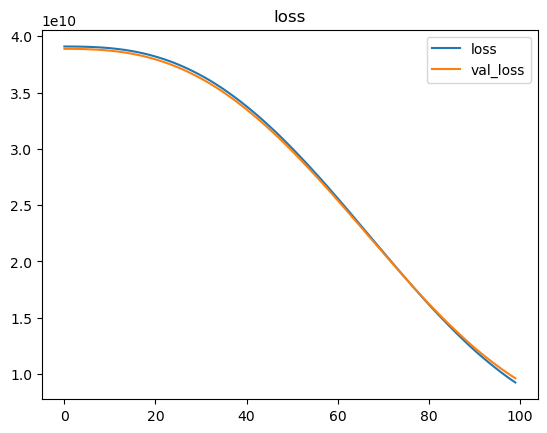

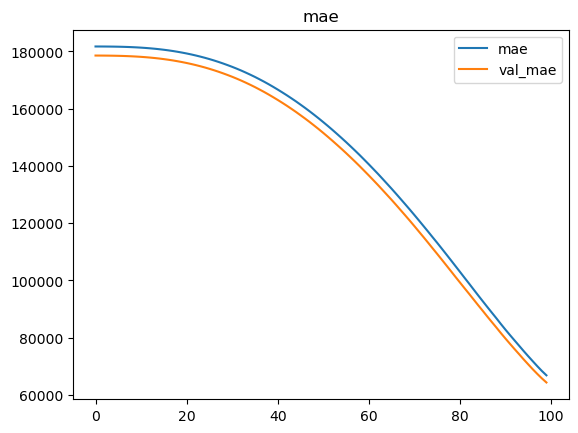

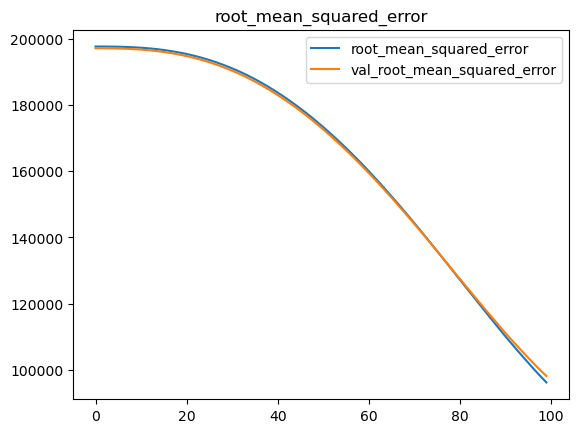

In [13]:
# Plotting history of base model
plot_history(history)

In [14]:
# Evaluating base model
train_preds = model.predict(X_train_proc)
test_preds = model.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='model_train')
test_scores = eval_regression(y_test, test_preds, name='model_test')

scores = pd.concat([train_scores, test_scores])
scores

12/12 [==============================] - 0s 455us/step


,RMSE,MAE,R2
Model Name,,,
model_train,95437.849857,66035.065675,-0.500200
model_test,98116.842869,64357.533968,-0.374231


- In our first model, the bias is high . To attack the high bias I will start off with adding more layers.

In [15]:
model2 = Sequential()
model2.add(Dense(10, activation='relu', input_dim=X_train_proc.shape[1]))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                3010      
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________


In [16]:
rmse = RootMeanSquaredError()

model2.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [17]:
history = model2.fit(X_train_proc, y_train,
                    validation_data = (X_test_proc, y_test),
                    epochs = 100)

Epoch 1/100
35/35 [==============================] - 1s 5ms/step - loss: 39090716672.0000 - mae: 181712.0156 - root_mean_squared_error: 197713.7188 - val_loss: 38884438016.0000 - val_mae: 178547.2812 - val_root_mean_squared_error: 197191.3750
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 39090302976.0000 - mae: 181710.9375 - root_mean_squared_error: 197712.6719 - val_loss: 38883758080.0000 - val_mae: 178545.4062 - val_root_mean_squared_error: 197189.6562
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 39089152000.0000 - mae: 181707.8125 - root_mean_squared_error: 197709.7656 - val_loss: 38882029568.0000 - val_mae: 178540.6406 - val_root_mean_squared_error: 197185.2656
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 39086571520.0000 - mae: 181700.8438 - root_mean_squared_error: 197703.2344 - val_loss: 38878388224.0000 - val_mae: 178530.5938 - val_root_mean_squared_error: 197176.0312
Epoch 5/100
35/35 [=========

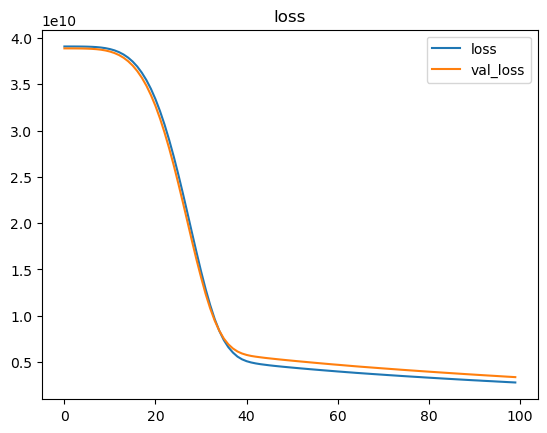

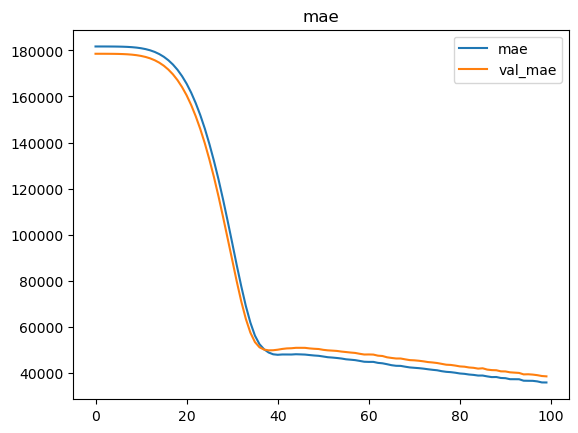

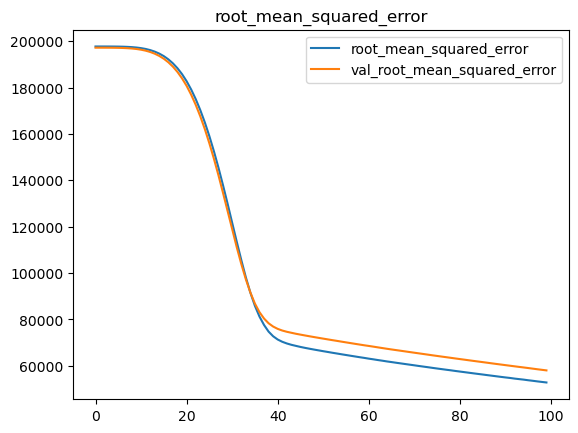

In [18]:
plot_history(history)

In [19]:
# Evaluating base model
train_preds = model2.predict(X_train_proc)
test_preds = model2.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='model2_train')
test_scores = eval_regression(y_test, test_preds, name='model2_test')

scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

12/12 [==============================] - 0s 545us/step


,RMSE,MAE,R2
Model Name,,,
model_train,95437.849857,66035.065675,-0.500200
model_test,98116.842869,64357.533968,-0.374231
model2_train,52683.843337,35605.048773,0.542846
model2_test,58033.775581,38451.443536,0.519233


- Model 2 still has a high bias. For the next model I will increase the number of epochs and add nodes.

In [20]:
model3 = Sequential()
model3.add(Dense(100, activation='relu', input_dim=X_train_proc.shape[1]))
model3.add(Dense(50, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(50, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               30100     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 1)                

In [21]:
rmse = RootMeanSquaredError()

model3.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [22]:
history = model3.fit(X_train_proc, y_train,
                    validation_data = (X_test_proc, y_test),
                    epochs = 100)

Epoch 1/100
35/35 [==============================] - 1s 6ms/step - loss: 39084859392.0000 - mae: 181696.3125 - root_mean_squared_error: 197698.9062 - val_loss: 38855663616.0000 - val_mae: 178468.2969 - val_root_mean_squared_error: 197118.4062
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 38821236736.0000 - mae: 180978.8281 - root_mean_squared_error: 197031.0625 - val_loss: 37913948160.0000 - val_mae: 175857.0781 - val_root_mean_squared_error: 194715.0469
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 34791575552.0000 - mae: 169575.3438 - root_mean_squared_error: 186525.0000 - val_loss: 27966599168.0000 - val_mae: 145475.7969 - val_root_mean_squared_error: 167232.1719
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 16053552128.0000 - mae: 99436.1094 - root_mean_squared_error: 126702.6094 - val_loss: 6026657280.0000 - val_mae: 51152.9688 - val_root_mean_squared_error: 77631.5469
Epoch 5/100
35/35 [=============

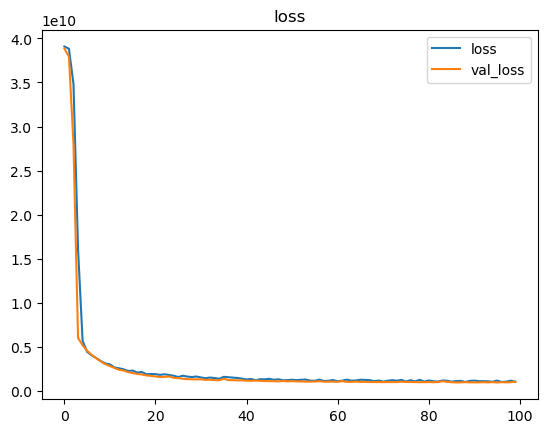

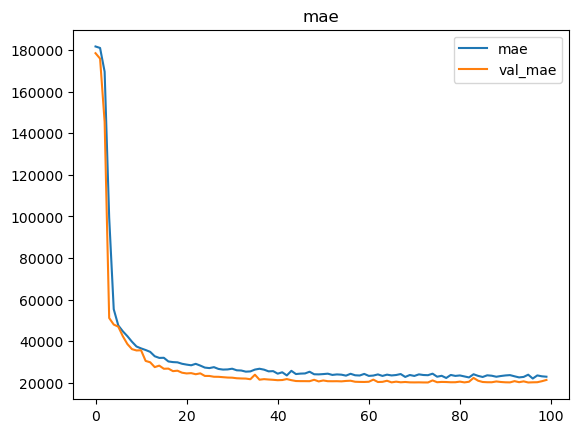

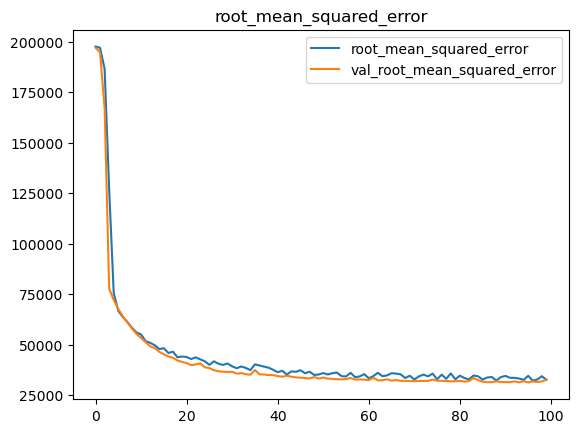

In [23]:
plot_history(history)

In [24]:
# Evaluating base model
train_preds = model3.predict(X_train_proc)
test_preds = model3.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='model3_train')
test_scores = eval_regression(y_test, test_preds, name='model3_test')

scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

12/12 [==============================] - 0s 636us/step


,RMSE,MAE,R2
Model Name,,,
model_train,95437.849857,66035.065675,-0.500200
model_test,98116.842869,64357.533968,-0.374231
model2_train,52683.843337,35605.048773,0.542846
model2_test,58033.775581,38451.443536,0.519233
model3_train,25361.048145,16677.283612,0.894064
model3_test,32640.181958,21378.061644,0.847918


In [25]:
model4 = Sequential()
model4.add(Dense(100, activation='relu', input_dim=X_train_proc.shape[1]))
model4.add(Dense(50, activation='relu'))
model4.add(Dropout(.2))
model4.add(Dense(50, activation='relu'))
model4.add(Dropout(.2))
model4.add(Dense(50, activation='relu'))
model4.add(Dense(1, activation='linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 1)                

In [26]:
rmse = RootMeanSquaredError()

model4.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model4.fit(X_train_proc, y_train,
                    validation_data = (X_test_proc, y_test),
                    epochs = 100,
                    callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 1s 6ms/step - loss: 39083925504.0000 - mae: 181693.5469 - root_mean_squared_error: 197696.5469 - val_loss: 38853292032.0000 - val_mae: 178461.1875 - val_root_mean_squared_error: 197112.3906
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 38831591424.0000 - mae: 180998.4219 - root_mean_squared_error: 197057.3281 - val_loss: 37961650176.0000 - val_mae: 175984.4375 - val_root_mean_squared_error: 194837.5000
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 35072720896.0000 - mae: 170256.9688 - root_mean_squared_error: 187277.1250 - val_loss: 28372817920.0000 - val_mae: 146801.7500 - val_root_mean_squared_error: 168442.3281
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 15919936512.0000 - mae: 99882.7188 - root_mean_squared_error: 126174.2344 - val_loss: 5977129984.0000 - val_mae: 51932.6836 - val_root_mean_squared_error: 77311.8984
Epoch 5/100
35/35 [=============

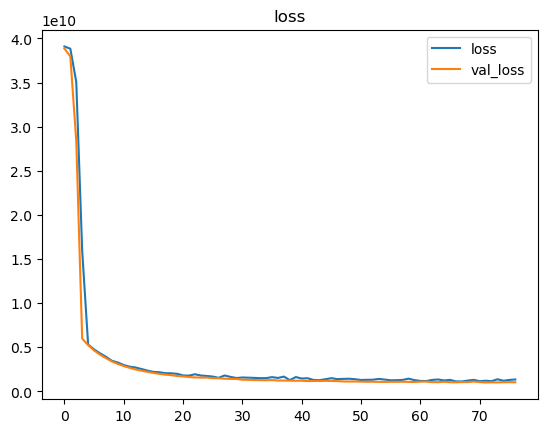

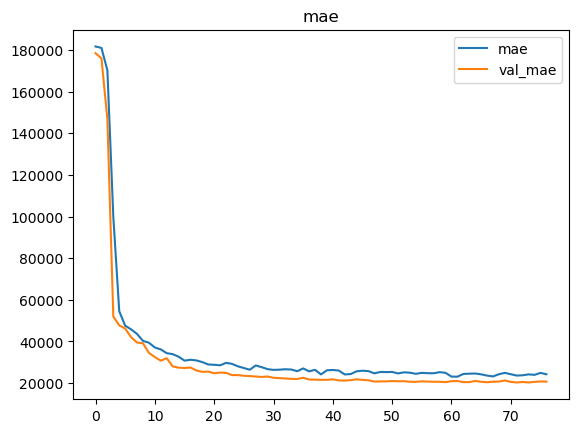

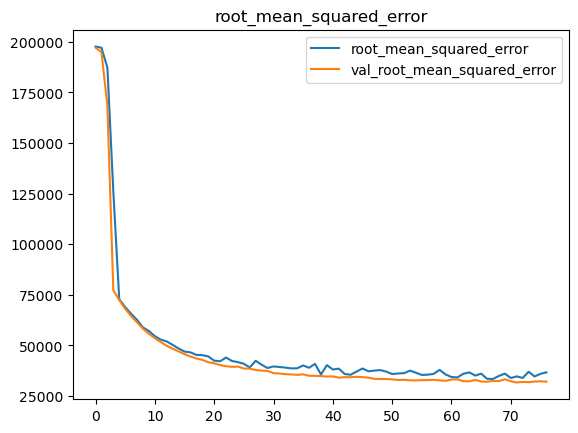

In [28]:
plot_history(history)

In [29]:
# Evaluating base model
train_preds = model4.predict(X_train_proc)
test_preds = model4.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='model4_train')
test_scores = eval_regression(y_test, test_preds, name='model4_test')

scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

12/12 [==============================] - 0s 636us/step


,RMSE,MAE,R2
Model Name,,,
model_train,95437.849857,66035.065675,-0.500200
model_test,98116.842869,64357.533968,-0.374231
model2_train,52683.843337,35605.048773,0.542846
model2_test,58033.775581,38451.443536,0.519233
model3_train,25361.048145,16677.283612,0.894064
model3_test,32640.181958,21378.061644,0.847918
model4_train,26116.717228,16515.679677,0.887657
model4_test,32103.326690,20721.083005,0.852880


- In my opinion, model 3 performed the best due to having the best R2 and having lower MAE and RMSE scores. Model 3 is able to make more accurate predictions.